Loading required packages

In [1]:
import pandas as pd
import numpy as np
import mne
import os

import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go

from scipy import signal
from scipy.signal import lfilter
from mne.time_frequency import tfr_morlet

EEG Recording Metadata


BaseFileName:0014;
FileOrder:1;

StartSample:0;

HardwareChannelNumbers:66;

Channels:1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,65;

ChannelType:,,,,,,,,,,,,,,,,,,,,,,,,,,,,;

ChannelName:Ch1,Ch2,Ch3,Ch4,Ch5,Ch6,Ch7,Ch8,Ch9,Ch10,Ch11,Ch12,Ch13,Ch14,Ch15,Ch16,Ch17,Ch18,Ch19,Ch20,Ch21,Ch22,Ch23,Ch24,Ch25,Ch26,Ch27,Ch28,Event1;

ChannelSampleRate:1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000;

ChannelResolution:24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24;

ChannelGain:4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4;

ChannelRange:9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9;

Notes:

Epoching: Dividing the continuous data into smaller segments, called epochs, that correspond to specific events or conditions. For example, the data can be divided into epochs corresponding to different tasks or stimuli.

Time-frequency analysis: Time-frequency analysis techniques, such as the Fourier transform or the wavelet transform are used to analyze the frequency content of EEG data over time. These techniques can be used to identify patterns or changes in the spectral power of the EEG signal that are related to specific events or conditions.

Tipically involves decomposing the signal into different frequency bands over time. This can be useful for studying how brain activity changes over time, and can be helpful in identifying specific patterns or changes in brain activity.

There are several methods for performing time-frequency analysis in Python, including:

Short-time Fourier transform (STFT): This method involves dividing the signal into small time intervals (called "windows") and performing a Fourier transform on each window to obtain the frequency content.

Wavelet transform: This method decomposes the signal into frequency bands using wavelets, which are specialized functions that are well-suited for analyzing time-varying signals.

Autoregressive model: This method involves fitting an autoregressive model to the data and using the model parameters to estimate the time-varying spectral content of the signal.

* To perform STFT analysis, scipy.signal.stft function can be used. 
* To perform wavelet analysis, use the pywt.cwt function from the PyWavelets library. 
* To fit an autoregressive model, use the statsmodels.tsa.ar_model.AR function from the statsmodels library.

EEG data often contains artifacts, such as eye blinks or muscle movements, that can affect the results of the time-frequency analysis. To remove these artifacts, it is usually necessary to pre-process the data using techniques such as artifact rejection or independent component analysis.

Feature extraction: Extract relevant features or characteristics of the signal that can be used to classify or analyze the data. For example, features such as the mean, standard deviation, or power spectral density of the signal within specific frequency bands or epochs can be extracted.

Classification: Once relevant features have been extracted ML techniques to classify the data ca be applied. For example, using supervised learning algorithms such as support vector machines or random forests to classify the data into different classes or groups.

Event-related potentials (ERPs) are changes in the electrical activity of the brain that are time-locked to specific events or stimuli. They are often used to study cognitive processes such as attention, perception, memory, and they can be measured using EEG.

To detect ERPs in EEG data:

* Preprocess the data: Preprocessing the data involves steps such as filtering, epoching, and removing artifacts. This is important to ensure that the data is clean and ready for analysis.

* Average the data: To detect ERPs, you typically need to average the EEG data across multiple trials or repetitions of the same event or stimulus. This helps to reduce the noise in the data and enhance the signal-to-noise ratio.

* Identify the ERP components: ERPs are often characterized by specific components or waves that are associated with different cognitive processes or brain regions. These components can be identified by their shape, amplitude, and latency.

* Analyze the data: Once the ERP components are idetnfieid, data can be analyzed to answer specific research questions. For example - compare the amplitudes or latencies of the ERP components between different conditions or groups, or use ML to classify the data based on the ERP components.

Entropy

* The Shannon entropy of a signal is a measure of the randomness or uncertainty of the signal. A signal with high Shannon entropy is considered more random or unpredictable, while a signal with low Shannon entropy is considered more predictable.

* Shannon entropy can be used to identify patterns or trends in the data that may not be immediately visible. For example, if the Shannon entropy of a particular EEG channel is consistently high over time, it may indicate that there is a high level of variability or unpredictability in the data. On the other hand, if the Shannon entropy is consistently low, it may indicate that there are clear patterns or trends in the data.

* Shannon entropy can be used on each EEG channel to identify patterns or trends in the data and understand how the brain is responding to different stimuli or tasks. hannon entropy can also be used to compare the data from different channels or subjects and see how they differ in terms of variability and predictability.

Manually computing the derivative within the EVENT1 column and applying a rolling window function over it

In [28]:
df = pd.read_csv("data/0014.txt", sep='\t', index_col=False, header=0)

# Apply the Noth filter
sampling_rate = 1000 # samples per second
notch_freq = 50 # Hz
notch_bw = 2 # Hz

eeg_mask = df.columns != 'EVENT1'

b, a = signal.iirnotch(notch_freq, notch_bw, sampling_rate)
filtered_data = signal.lfilter(b, a, df.loc[:, eeg_mask], axis=0)
filtered_df = df.copy()
filtered_df.loc[:, eeg_mask] = filtered_data

# Calculate the difference between consecutive values in the "EVENT1" column
filtered_df['derivative'] = filtered_df['EVENT1'].diff()

# Define the window size (in number of rows)
window_size = 5
rolling_window = filtered_df['derivative'].rolling(window_size)
filtered_df['window'] = rolling_window.mean()

In [31]:
# Check the newly created derivative and window columns and apply a filter to exclude NaN and 0
filtered_df.iloc[:, -2:][((filtered_df.iloc[:, -2:].notna()) & (filtered_df.iloc[:, -2:].ne(0))).all(1)]

,derivative,window
33402,16.0,3.2
33405,8.0,4.8
33408,32.0,8.0
33435,64.0,12.8
53656,-96.0,-19.2
...,...,...
253239,64.0,12.8
262762,-64.0,-12.8
262777,-32.0,-6.4
262780,-16.0,-9.6


In [6]:
# Calculate the counts of each unique value in the window column
print(filtered_df.value_counts("window"))

window
 0.0     273821
 12.8       405
 3.2        403
 6.4        403
-22.4       297
-19.2        61
-3.2         61
-12.8        47
-9.6         43
-6.4          3
-4.8          3
 4.8          2
 8.0          2
-11.2         1
-1.6          1
 1.6          1
dtype: int64


In [7]:
# Calculate the counts of each unique value in the derivative column
print(filtered_df.value_counts('derivative'))

derivative
 0.0     275127
 16.0        81
 32.0        81
 64.0        81
-16.0        62
-64.0        43
-96.0        38
-32.0        24
-48.0        19
-8.0          1
 8.0          1
dtype: int64


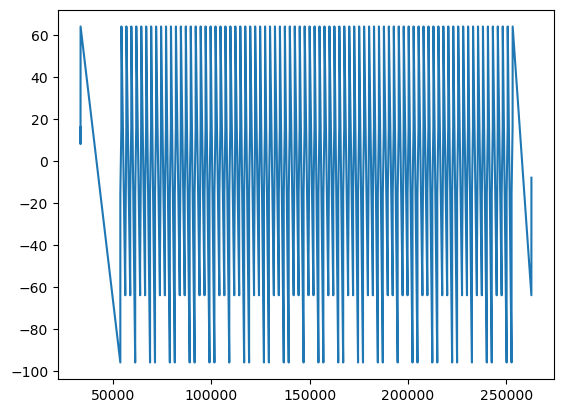

In [8]:
der = filtered_df[filtered_df['derivative'] != 0]
# Plot the filtered series
der['derivative'].plot()
plt.show()

# Attempting MNE conversion

* Starting fresh with preparing the raw & info MNE objects

In [113]:
data = pd.read_csv("data/0014.txt", sep='\t', index_col=False, header=0)

sampling_rate = 1000 # signal samples per second
notch_freq = 50 #Hz
notch_bw = 2 #Hz

eeg_mask = data.columns != 'EVENT1'

b, a = signal.iirnotch(notch_freq, notch_bw, sampling_rate)
filtered_data = signal.lfilter(b, a, data.loc[:, eeg_mask], axis=0)
filtered_df = data.copy()
filtered_df.loc[:, eeg_mask] = filtered_data

# extract the data as a numpy array for faster processing
eeg_data = filtered_df.values[:, ].T

# creating an MNE info object to define and store metadata, including stimuli 
n_channels = eeg_data.shape[0]
ch_names = ['CH{}'.format(i) for i in range(1, n_channels)] + ['EVENT1']
ch_types = ['eeg'] * (len(ch_names) - 1) + ['stim']
sfreq = 1000
info = mne.create_info(ch_names, sfreq, ch_types)

# create an MNE RawArray object
raw = mne.io.RawArray(eeg_data, info)

# print information about the data
print(raw.info)

Creating RawArray with float64 data, n_channels=29, n_times=275559
    Range : 0 ... 275558 =      0.000 ...   275.558 secs
Ready.
<Info | 7 non-empty values
 bads: []
 ch_names: CH1, CH2, CH3, CH4, CH5, CH6, CH7, CH8, CH9, CH10, CH11, CH12, ...
 chs: 28 EEG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: unspecified
 nchan: 29
 projs: []
 sfreq: 1000.0 Hz
>


In [117]:
events = mne.find_events(raw, stim_channel='EVENT1')
print(events[:10])  # show the first N events

244 events found
Event IDs: [ 16  24  56 120]
[[33402     0    16]
 [33405    16    24]
 [33408    24    56]
 [33435    56   120]
 [54176     8    24]
 [54185    24    56]
 [54218    56   120]
 [56696     8    24]
 [56704    24    56]
 [56737    56   120]]


In [118]:
# Applying additional high and low band filters over the signal native to the MNE package
raw.filter(l_freq=1, h_freq=None)
raw.filter(l_freq=None, h_freq=40)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3301 samples (3.301 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    0.1s finished


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    0.2s finished


<RawArray | 29 x 275559 (275.6 s), ~61.0 MB, data loaded>

In [119]:
events = mne.find_events(raw, stim_channel='EVENT1', shortest_event=0.1, verbose=True, initial_event=True, uint_cast=True)
event_id = {'Stimulus': 120} #Event IDs: [ 16  24  56 120]
tmin = -1  # start time before the event
tmax = 1  # end time after the event
baseline = None  # no baseline correction
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline=baseline, preload=True)
print(epochs)

244 events found
Event IDs: [ 16  24  56 120]
Not setting metadata
81 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 81 events and 2001 original time points ...
0 bad epochs dropped
<Epochs |  81 events (all good), -1 - 1 sec, baseline off, ~35.9 MB, data loaded,
 'Stimulus': 81>


In [120]:
# call the epoch opbject to see the details as defined by MNE
epochs

Number of events,81
Events,Stimulus: 81
Time range,-1.000 – 1.000 sec
Baseline,off


# Basic visualization

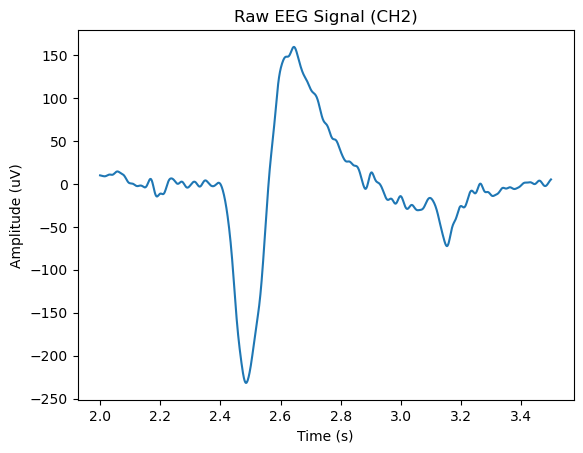

In [121]:
# pick a channel to plot
channel_index = 1
channel_name = raw.ch_names[channel_index]

# select a time range to plot (divide by 1000 to convert to seconds)
start_time = 2000 # change these values to see how the signal changes over time
end_time = 3500

# extract the data for the selected channel and time range
data, times = raw[channel_index, start_time:end_time]

# plot the data
fig, ax = plt.subplots()
ax.plot(times, data.T)
ax.set(title=f'Raw EEG Signal ({channel_name})', xlabel='Time (s)', ylabel='Amplitude (uV)')
plt.show()

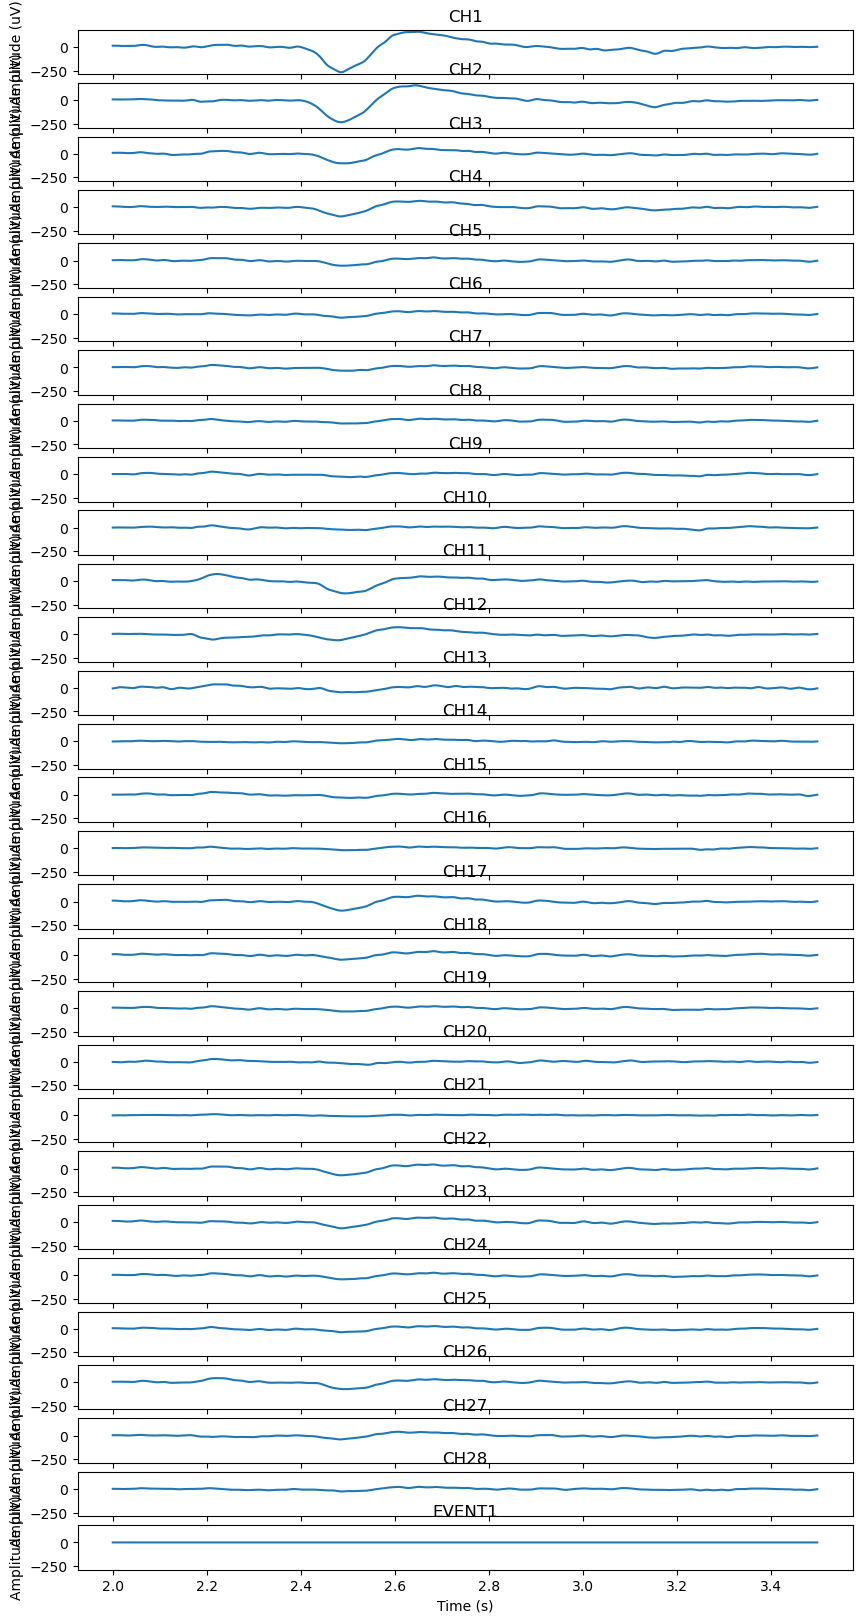

In [122]:
# Plot all channels sequentially
start_time = 2000
end_time = 3500

# plot all channels
fig, axes = plt.subplots(nrows=len(raw.ch_names), sharex=True, sharey=True, figsize=(10, 20))
for channel_index, channel_name in enumerate(raw.ch_names):
    # extract the data for the selected channel and time range
    data, times = raw[channel_index, start_time:end_time]
    # plot the data
    axes[channel_index].plot(times, data.T)
    axes[channel_index].set(title=channel_name, ylabel='Amplitude (uV)')
axes[-1].set(xlabel='Time (s)')
plt.show()

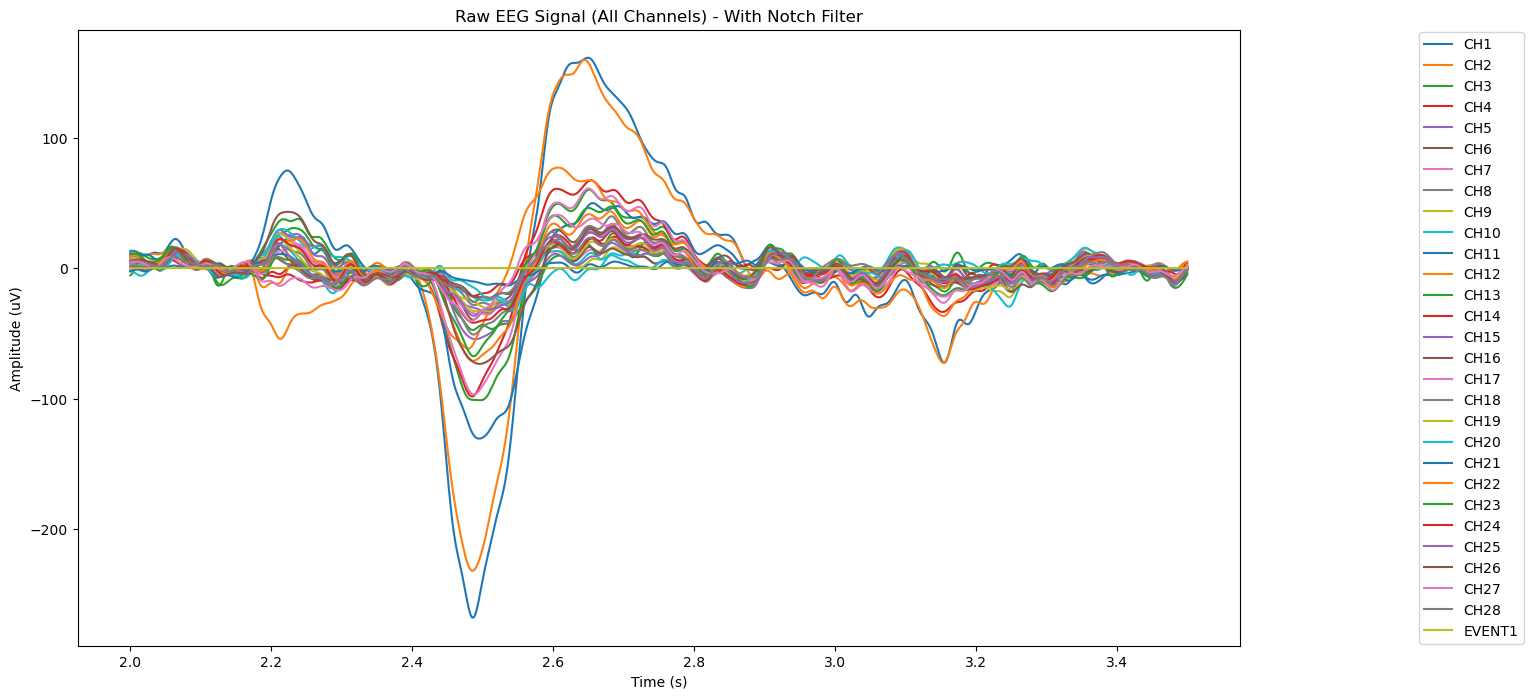

In [123]:
# Stack all channels on top of eachother
# select a time range to plot
start_time = 2000
end_time = 3500

# extract the data for the selected time range
data, times = raw[:, start_time:end_time]

# plot the data
fig, ax = plt.subplots(figsize=(15, 8))
for i in range(data.shape[0]):
    ax.plot(times, data[i, :], label=raw.ch_names[i])
ax.set(title='Raw EEG Signal (All Channels) - With Notch Filter', xlabel='Time (s)', ylabel='Amplitude (uV)')
ax.legend(loc='right', bbox_to_anchor=(1.25, 0.5))
plt.show()

# Interactive plot

In [124]:
# select a time range to plot
start_time = 2000
end_time = 3500

# extract the data for the selected time range
data, times = raw[:, start_time:end_time]

# create a list of traces, one for each channel
traces = []
for i, channel_name in enumerate(raw.ch_names):
    trace = go.Scatter(x=times, y=data[i], name=channel_name)
    traces.append(trace)

# create the plot layout
layout = go.Layout(title='Raw EEG Signal (All Channels) - With Notch Filter',
                   xaxis=dict(title='Time (s)'),
                   yaxis=dict(title='Amplitude (uV)'),
                   legend=dict(x=1.1, y=1))

# create the plot
fig = go.Figure(data=traces, layout=layout)
fig.update_layout(width=1500, height=900) # change these values to fit the plot to your screen size
fig.update_layout(xaxis=dict(gridcolor='rgba(0,0,0,0)'),
                  yaxis=dict(gridcolor='rgba(0,0,0,0)')) # Removing the gridlines from the plot
# show the plot
fig.show()

# MNE Processing

Not setting metadata
81 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 81 events and 2001 original time points ...
0 bad epochs dropped


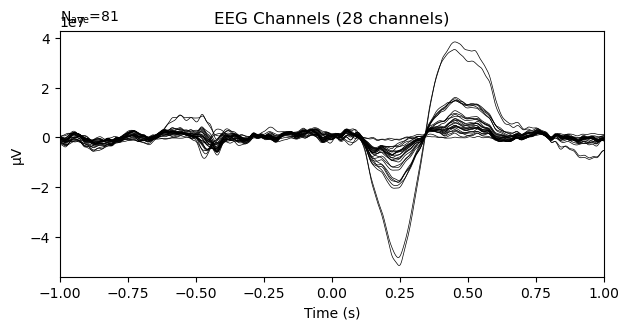

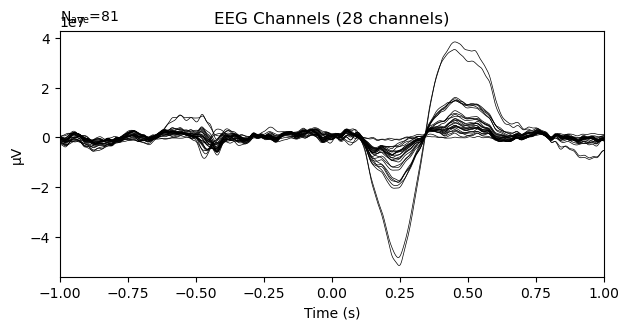

In [125]:
# ERP Plot
# extract epochs from the raw data
epochs = mne.Epochs(raw, events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=None, preload=True)
# compute the evoked response
evoked = epochs.average()
# plot the evoked response
evoked.plot(time_unit='s', picks='eeg', titles=dict(eeg='EEG Channels'))

Work in progress - compute power spectrum and time frequency analysis 



* For this to work, perhaps we need to provide additional metadata related to postion of the electrodes

In [ ]:
# import pandas as pd
# import numpy as np
# import mne
# from mne.channels import make_standard_montage

# from scipy import signal

# df = pd.read_csv("data/0014.txt", sep='\t', index_col=False, header=0)
# df = df.iloc[:, :-1]

# # Create the MNE info object with metadata about the EEG channels
# n_channels = df.shape[1]
# ch_names = list(df.columns)
# ch_types = ['eeg'] * n_channels
# sfreq = 1000
# info = mne.create_info(ch_names, sfreq, ch_types)
# info

In [126]:
frequencies = np.arange(6, 30, 2)  # frequency range
n_cycles = 3  # number of cycles in Morlet wavelet
power = tfr_morlet(epochs, freqs=frequencies, n_cycles=n_cycles, return_itc=False)
power.plot_topo(baseline=(-0.5, 0), mode='zscore', title='Time-Frequency Plot')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.0s remaining:    0.0s


Applying baseline correction (mode: zscore)


[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    7.9s finished


RuntimeError: No digitization points found.

Topographic plot

In [ ]:
evoked.plot_topomap(times=[0.1, 0.2, 0.3])

Attemp to map the stimuli details

In [34]:
stimuli_df = pd.read_excel("data/FacesERP_05.xls")
stimuli_df

,Block,Condition,Exp,Exp.Sample,Stimuli
0,1,ScrambledFace,79,1,sm19.bmp
1,2,UprightFace,23,2,bwm03.bmp
2,3,ScrambledFace,65,3,sm05.bmp
3,4,UprightFace,40,4,bwm20.bmp
4,5,InvertedFace,5,5,bwi05.bmp
...,...,...,...,...,...
75,76,InvertedFace,12,76,bwi12.bmp
76,77,InvertedFace,13,77,bwi13.bmp
77,78,InvertedFace,6,78,bwi06.bmp
78,79,Object,55,79,o15.bmp


In [35]:
df = pd.read_csv("data/0014.txt", sep='\t', index_col=False, header=0)
frequency = 1000  #Hz
total_samples = df.shape[0]
recording_duration = total_samples / frequency
experiment_start_time = '07-18-2022 14:03:07'
experiment_start_time = pd.to_datetime(experiment_start_time, format='%m-%d-%Y %H:%M:%S')
timestamps = pd.date_range(start=experiment_start_time, freq=f'{1/frequency}S', periods=total_samples)
df['TIMESTAMP'] = timestamps
df

,CH1,CH2,CH3,CH4,CH5,CH6,CH7,CH8,CH9,CH10,...,CH21,CH22,CH23,CH24,CH25,CH26,CH27,CH28,EVENT1,TIMESTAMP
0,-22.10,-21.76,-23.02,-13.96,-17.21,-14.86,-17.11,-16.89,-17.81,-19.57,...,-20.81,-16.96,-16.27,-15.64,-14.51,-20.63,-10.40,-17.09,0,2022-07-18 14:03:07.000
1,-21.01,-21.05,-22.75,-14.21,-17.33,-15.03,-16.83,-16.86,-17.48,-19.37,...,-20.65,-17.07,-16.14,-15.61,-14.61,-20.23,-10.64,-17.28,0,2022-07-18 14:03:07.001
2,-17.29,-13.84,-19.72,-11.73,-14.80,-12.51,-13.56,-13.96,-14.46,-16.48,...,-17.71,-14.54,-12.47,-12.81,-12.01,-17.20,-8.08,-14.68,0,2022-07-18 14:03:07.002
3,-9.22,4.01,-12.39,-4.71,-7.95,-5.53,-5.41,-6.29,-6.96,-9.12,...,-10.19,-7.67,-3.01,-5.42,-4.92,-9.87,-0.88,-7.51,0,2022-07-18 14:03:07.003
4,3.10,32.33,-0.78,7.03,3.25,5.99,7.63,6.24,5.05,2.71,...,1.82,3.66,12.36,6.57,6.77,1.71,11.12,4.32,0,2022-07-18 14:03:07.004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275554,11.50,3.44,3.57,5.68,7.01,1.73,5.27,2.80,10.65,8.15,...,9.85,4.61,-5.01,4.37,0.73,9.98,1.87,1.28,0,2022-07-18 14:07:42.554
275555,12.13,5.05,4.17,7.21,7.81,3.41,6.00,3.91,11.08,8.87,...,10.22,5.74,-2.99,5.52,2.18,10.13,4.00,2.38,0,2022-07-18 14:07:42.555
275556,12.08,5.21,4.03,7.71,7.80,4.19,5.94,4.28,10.76,8.89,...,9.90,6.06,-2.00,5.85,2.79,9.48,4.95,2.69,0,2022-07-18 14:07:42.556
275557,11.85,4.72,3.61,7.38,7.41,4.25,5.48,4.17,10.15,8.60,...,9.33,5.95,-1.70,5.75,2.87,8.55,4.52,2.43,0,2022-07-18 14:07:42.557
